In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import glob
# from upsetplot import from_contents, plot
from matplotlib import pyplot

from pathlib import Path

from dfmodel import DigitalFamilyBinary

In [2]:
design_matrix_test = pd.read_csv(
    "../0_data/design_matrix_test.tsv",
    sep='\t'
)

In [3]:
design_matrix = pd.read_csv(
    "../0_data/design_matrix_train.tsv",
    sep='\t'
)

In [4]:
design_matrix.shape

(680, 65)

In [5]:
clinical_columns = [
    "sao2_ambulance",
    "resp_frequency_ambulance",
    "heart_rate_ambulance",
    "syst_bp_ambulance",
    "map_ambulance",
    "mental_status_ambulance",
    "temperature_ambulance",
    "crea_emergency_department",
    "bili_emergency_department",
    "crp_day1",
    "trc_emergency_department",
    "sex",
    "age"
]

continuous_clinical_columns = [
    "sao2_ambulance",
    "resp_frequency_ambulance",
    "heart_rate_ambulance",
    "syst_bp_ambulance",
    "map_ambulance",
    "temperature_ambulance",
    "crea_emergency_department",
    "bili_emergency_department",
    "trc_emergency_department",
    "crp_day1",
    "age"
]

categorical_clinical_columns = [
    "mental_status_ambulance", 
]

In [6]:
design_matrix['survival_30_day'] = np.where(design_matrix['survival_days'] <= 30, 1, 0)
design_matrix_test['survival_30_day'] = np.where(design_matrix_test['survival_days'] <= 30, 1, 0)

# 30-day Mortality 

In [7]:
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.impute import SimpleImputer

training_data = design_matrix.copy()
testing_data = design_matrix_test.copy()

clinical_scaler = StandardScaler()

clinical_imputer = SimpleImputer()
constant_imputer = SimpleImputer(strategy="constant", fill_value=0.0)

training_data[continuous_clinical_columns] = clinical_imputer.fit_transform(training_data[continuous_clinical_columns])
training_data[categorical_clinical_columns] = constant_imputer.fit_transform(training_data[categorical_clinical_columns])

training_data[continuous_clinical_columns] = clinical_scaler.fit_transform(training_data[continuous_clinical_columns])


testing_data[continuous_clinical_columns] = clinical_imputer.transform(testing_data[continuous_clinical_columns])
testing_data[categorical_clinical_columns] = constant_imputer.transform(testing_data[categorical_clinical_columns])

testing_data[continuous_clinical_columns] = clinical_scaler.transform(testing_data[continuous_clinical_columns])

In [8]:
df_estimator = DigitalFamilyBinary()

df_estimator.fit(training_data, features=clinical_columns)

In [9]:
testing_data['Mortality 30 Day Prob'] = df_estimator.predict(
    testing_data[clinical_columns], 
    features=clinical_columns, 
    target_column="survival_30_day"
)

In [10]:
combined_results = pd.concat([testing_data,  df_estimator.bootstrap_results_df], axis=1)

In [11]:

bootstrap_counts = []


for bootstrap_iteration in df_estimator.bootstrap_columns:


    mort_range = combined_results[bootstrap_iteration].unique()
    mort_range.sort()
    actual_mort = []
    #mort_range = mort_range[:-1]
    counts_per_bin = []
    for val in mort_range:

        counts = combined_results[combined_results[bootstrap_iteration] == val]['survival_30_day'].value_counts()
        actual_mort.append(counts.get(1, 0) / (counts.get(0, 0) + counts.get(1, 0)))
        counts_per_bin.append(counts.sum())

    estimated_mort = pd.DataFrame(
        {
            "Actual Mortality (30-Day)": actual_mort,
            "Estimated Mortality (30-Day)": mort_range,
            "Counts": counts_per_bin
        }
    )

    bootstrap_counts.append(estimated_mort)

In [12]:
bootstrap_counts = pd.concat(bootstrap_counts)

In [13]:
bootstrap_counts.head(20)

,Actual Mortality (30-Day),Estimated Mortality (30-Day),Counts
0,0.075650,0.0,423
1,0.169935,0.1,153
2,0.166667,0.2,66
3,0.250000,0.3,24
4,0.666667,0.4,9
5,0.500000,0.5,4
6,1.000000,0.6,1
0,0.062814,0.0,398
1,0.158824,0.1,170
2,0.214286,0.2,70


In [14]:
bootstrap_counts.to_csv(
    "mortality_df.tsv",
    sep="\t",
    index=False
)

In [15]:
from scipy import stats
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

In [16]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()

linreg.fit(bootstrap_counts[['Estimated Mortality (30-Day)']], bootstrap_counts[['Actual Mortality (30-Day)']])

LinearRegression()

In [17]:
from scipy.stats import linregress


linregress_results = linregress(bootstrap_counts[['Estimated Mortality (30-Day)']].values.ravel(), bootstrap_counts[['Actual Mortality (30-Day)']].values.ravel())
linregress_results


LinregressResult(slope=1.3642671125810037, intercept=-0.00034086402316202413, rvalue=0.8595456604239382, pvalue=6.509122220507834e-197, stderr=0.03138435669952884, intercept_stderr=0.010867126267789719)

In [18]:
from sklearn.metrics import mean_squared_error, r2_score

predictions = linregress_results.intercept + linregress_results.slope*bootstrap_counts[['Estimated Mortality (30-Day)']].values.ravel()

In [19]:
from scipy.stats import pearsonr

corr, pval = pearsonr(
    bootstrap_counts[['Estimated Mortality (30-Day)']].values.ravel(), bootstrap_counts[['Actual Mortality (30-Day)']].values.ravel()
)

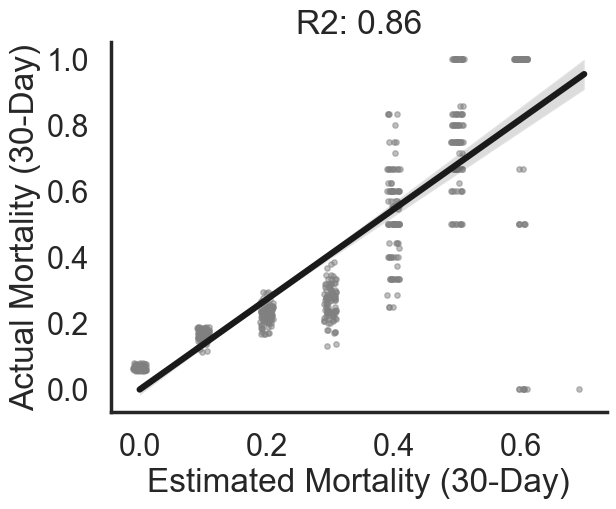

In [20]:
import matplotlib.pyplot as plt

sns.set_theme(context="poster", style="white", font_scale=1)

fig, ax = plt.subplots()

sns.regplot(
    data=bootstrap_counts,
    x="Estimated Mortality (30-Day)",
    y="Actual Mortality (30-Day)",
    ax=ax,
    scatter_kws={"color": "gray", "alpha": 0.5, "s": 15},
    line_kws={"color": "k", "alpha": 1},
    fit_reg=True,
    ci=95,
    x_jitter=0.01
)

ax.set_title(
    f"R2: {corr:.2f}"
)

sns.despine()


In [21]:
estimated_mort['Predicted Fit'] = linreg.predict(estimated_mort[['Estimated Mortality (30-Day)']])

In [22]:
fig.savefig("mortality.pdf", dpi=300, bbox_inches="tight")

In [23]:
combined_results.to_csv(
    "design_matrix_test_mortality_risk.tsv",
    sep="\t"
)

# Deterioration

In [24]:
training_data = design_matrix[
    #(X['sofa_score_increase_day1'] < 2) &
    (~design_matrix['sofa_score_increase_day2'].isna()) &
    (~design_matrix['sofa_score_increase_day3'].isna())
].copy()

In [25]:
testing_data = design_matrix_test[
     #(X_test['sofa_score_increase_day1'] < 2) &
    (~design_matrix_test['sofa_score_increase_day2'].isna()) &
    (~design_matrix_test['sofa_score_increase_day3'].isna())
].copy()

In [26]:
training_data['future_deterioration'] = np.where(
    training_data['sofa_score_increase_day2'] > 1, 1, np.where(
        training_data['sofa_score_increase_day3'] > 1, 1, 0
    )
)

testing_data['future_deterioration'] = np.where(
    testing_data['sofa_score_increase_day2'] > 1, 1, np.where(
        testing_data['sofa_score_increase_day3'] > 1, 1, 0
    )
)

In [27]:
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.impute import SimpleImputer

clinical_scaler = StandardScaler()

clinical_imputer = SimpleImputer()
constant_imputer = SimpleImputer(strategy="constant", fill_value=0.0)

training_data[continuous_clinical_columns] = clinical_imputer.fit_transform(training_data[continuous_clinical_columns])
training_data[categorical_clinical_columns] = constant_imputer.fit_transform(training_data[categorical_clinical_columns])

training_data[continuous_clinical_columns] = clinical_scaler.fit_transform(training_data[continuous_clinical_columns])


testing_data[continuous_clinical_columns] = clinical_imputer.transform(testing_data[continuous_clinical_columns])
testing_data[categorical_clinical_columns] = constant_imputer.transform(testing_data[categorical_clinical_columns])

testing_data[continuous_clinical_columns] = clinical_scaler.transform(testing_data[continuous_clinical_columns])

In [28]:
df_estimator = DigitalFamilyBinary()

df_estimator.fit(training_data, features=clinical_columns)

In [29]:
testing_data['Future Deterioration Mean'] = df_estimator.predict(
    testing_data[clinical_columns], 
    features=clinical_columns, 
    target_column="future_deterioration"
)

In [30]:
combined_results = pd.concat([testing_data.reset_index(),  df_estimator.bootstrap_results_df], axis=1)

In [31]:

bootstrap_counts = []


for bootstrap_iteration in df_estimator.bootstrap_columns:


    mort_range = combined_results[bootstrap_iteration].unique()
    mort_range.sort()
    actual_mort = []
    #mort_range = mort_range[:-1]
    counts_per_bin = []
    for val in mort_range:

        counts = combined_results[combined_results[bootstrap_iteration] == val]['future_deterioration'].value_counts()
        actual_mort.append(counts.get(1, 0) / (counts.get(0, 0) + counts.get(1, 0)))
        counts_per_bin.append(counts.sum())

    estimated_mort = pd.DataFrame(
        {
            "Actual Deterioration": actual_mort,
            "Estimated Deterioration": mort_range,
            "Counts": counts_per_bin
        }
    )

    bootstrap_counts.append(estimated_mort)

In [32]:
bootstrap_counts = pd.concat(bootstrap_counts)

In [33]:
bootstrap_counts.head(20)

,Actual Deterioration,Estimated Deterioration,Counts
0,1.000000,0.0,1
1,0.166667,0.1,6
2,0.318182,0.2,22
3,0.467742,0.3,62
4,0.531646,0.4,79
5,0.563492,0.5,126
6,0.589928,0.6,139
7,0.579545,0.7,88
8,0.744681,0.8,47
9,0.888889,0.9,18


In [34]:
bootstrap_counts.to_csv(
    "deterioration_df.tsv",
    sep="\t",
    index=False
)

In [35]:
from scipy import stats
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

In [36]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()

linreg.fit(bootstrap_counts[['Estimated Deterioration']], bootstrap_counts[['Actual Deterioration']])

LinearRegression()

In [37]:
from scipy.stats import linregress


linregress_results = linregress(bootstrap_counts[['Estimated Deterioration']].values.ravel(), bootstrap_counts[['Actual Deterioration']].values.ravel())
linregress_results


LinregressResult(slope=0.6249680558028458, intercept=0.2256043568940751, rvalue=0.852150542317301, pvalue=2.332817119280318e-293, stderr=0.011929420012490482, intercept_stderr=0.00726875977492855)

In [38]:
from sklearn.metrics import mean_squared_error, r2_score

predictions = linregress_results.intercept + linregress_results.slope*bootstrap_counts[['Estimated Deterioration']].values.ravel()

In [39]:
from scipy.stats import pearsonr

corr, pval = pearsonr(
    bootstrap_counts[['Estimated Deterioration']].values.ravel(), bootstrap_counts[['Actual Deterioration']].values.ravel()
)

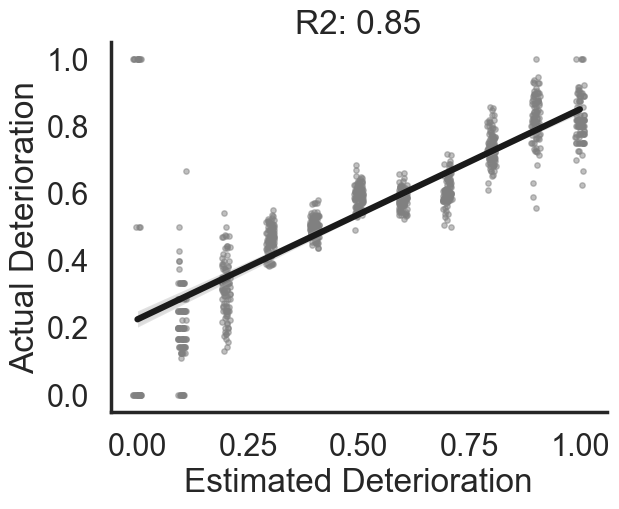

In [40]:
import matplotlib.pyplot as plt

sns.set_theme(context="poster", style="white", font_scale=1)

fig, ax = plt.subplots()

sns.regplot(
    data=bootstrap_counts,
    x="Estimated Deterioration",
    y="Actual Deterioration",
    ax=ax,
    scatter_kws={"color": "gray", "alpha": 0.5, "s": 15},
    line_kws={"color": "k", "alpha": 1},
    fit_reg=True,
    ci=95,
    x_jitter=0.01
)

ax.set_title(
    f"R2: {corr:.2f}"
)

sns.despine()

In [41]:
fig.savefig("deterioration.pdf", dpi=300, bbox_inches="tight")

In [42]:
combined_results.to_csv(
    "design_matrix_test_deterioration.tsv",
    sep="\t"
)

# Sepsis

In [43]:
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.impute import SimpleImputer

training_data = design_matrix.copy()
testing_data = design_matrix_test.copy()

clinical_scaler = StandardScaler()

clinical_imputer = SimpleImputer()
constant_imputer = SimpleImputer(strategy="constant", fill_value=0.0)

training_data[continuous_clinical_columns] = clinical_imputer.fit_transform(training_data[continuous_clinical_columns])
training_data[categorical_clinical_columns] = constant_imputer.fit_transform(training_data[categorical_clinical_columns])

training_data[continuous_clinical_columns] = clinical_scaler.fit_transform(training_data[continuous_clinical_columns])


testing_data[continuous_clinical_columns] = clinical_imputer.transform(testing_data[continuous_clinical_columns])
testing_data[categorical_clinical_columns] = constant_imputer.transform(testing_data[categorical_clinical_columns])

testing_data[continuous_clinical_columns] = clinical_scaler.transform(testing_data[continuous_clinical_columns])

In [44]:
df_estimator = DigitalFamilyBinary()

df_estimator.fit(training_data, features=clinical_columns)

In [45]:
testing_data['Sepsis Prob'] = df_estimator.predict(
    testing_data[clinical_columns], 
    features=clinical_columns, 
    target_column="sepsis_or_septic_shock"
)

In [46]:
combined_results = pd.concat([testing_data,  df_estimator.bootstrap_results_df], axis=1)

In [47]:

bootstrap_counts = []

for bootstrap_iteration in df_estimator.bootstrap_columns:


    mort_range = combined_results[bootstrap_iteration].unique()
    mort_range.sort()
    actual_mort = []
    #mort_range = mort_range[:-1]
    counts_per_bin = []
    for val in mort_range:

        counts = combined_results[combined_results[bootstrap_iteration] == val]['sepsis_or_septic_shock'].value_counts()
        actual_mort.append(counts.get(1, 0) / (counts.get(0, 0) + counts.get(1, 0)))
        counts_per_bin.append(counts.sum())

    estimated_mort = pd.DataFrame(
        {
            "Actual Sepsis": actual_mort,
            "Estimated Sepsis": mort_range,
            "Counts": counts_per_bin
        }
    )

    bootstrap_counts.append(estimated_mort)

In [48]:
bootstrap_counts = pd.concat(bootstrap_counts)

In [49]:
bootstrap_counts.head(20)

,Actual Sepsis,Estimated Sepsis,Counts
0,0.000000,0.0,1
1,0.400000,0.1,5
2,0.153846,0.2,13
3,0.333333,0.3,33
4,0.333333,0.4,45
5,0.640777,0.5,103
6,0.622642,0.6,106
7,0.744361,0.7,133
8,0.805310,0.8,113
9,0.858824,0.9,85


In [50]:
bootstrap_counts.to_csv(
    "sepsis_df.tsv",
    sep="\t",
    index=False
)

In [51]:
from scipy import stats
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

In [52]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()

linreg.fit(bootstrap_counts[['Estimated Sepsis']], bootstrap_counts[['Actual Sepsis']])

LinearRegression()

In [53]:
from scipy.stats import linregress


linregress_results = linregress(bootstrap_counts[['Estimated Sepsis']].values.ravel(), bootstrap_counts[['Actual Sepsis']].values.ravel())
linregress_results


LinregressResult(slope=0.8406855826779907, intercept=0.111914883839757, rvalue=0.9343958814267687, pvalue=0.0, stderr=0.009957745862679444, intercept_stderr=0.006064153197765116)

In [54]:
from sklearn.metrics import mean_squared_error, r2_score

predictions = linregress_results.intercept + linregress_results.slope*bootstrap_counts[['Estimated Sepsis']].values.ravel()

In [55]:
from scipy.stats import pearsonr

corr, pval = pearsonr(
    bootstrap_counts[['Estimated Sepsis']].values.ravel(), bootstrap_counts[['Actual Sepsis']].values.ravel()
)

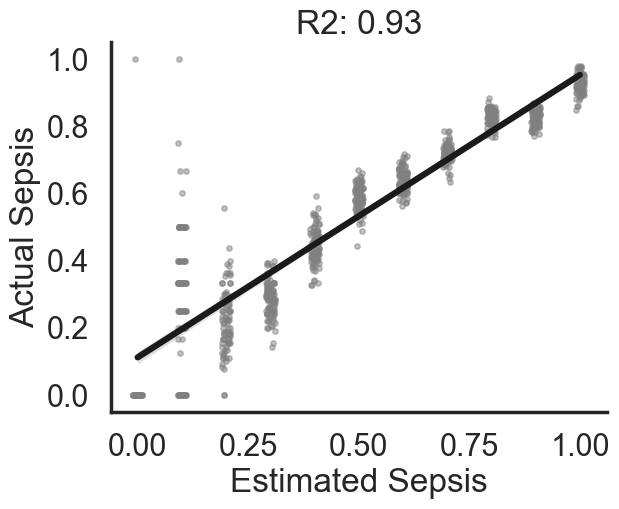

In [56]:
import matplotlib.pyplot as plt

sns.set_theme(context="poster", style="white", font_scale=1)

fig, ax = plt.subplots()

sns.regplot(
    data=bootstrap_counts,
    x="Estimated Sepsis",
    y="Actual Sepsis",
    ax=ax,
    scatter_kws={"color": "gray", "alpha": 0.5, "s": 15},
    line_kws={"color": "k", "alpha": 1},
    fit_reg=True,
    ci=95,
    x_jitter=0.01
)

ax.set_title(
    f"R2: {corr:.2f}"
)

sns.despine()

In [57]:
combined_results.to_csv(
    "design_matrix_test_sepsis_risk.tsv",
    sep="\t",
    index=False
)

In [58]:
fig.savefig("sepsis_diagnosis.pdf", dpi=300, bbox_inches="tight")

# Infection

In [59]:
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.impute import SimpleImputer

training_data = design_matrix.copy()
testing_data = design_matrix_test.copy()

clinical_scaler = StandardScaler()

clinical_imputer = SimpleImputer()
constant_imputer = SimpleImputer(strategy="constant", fill_value=0.0)

training_data[continuous_clinical_columns] = clinical_imputer.fit_transform(training_data[continuous_clinical_columns])
training_data[categorical_clinical_columns] = constant_imputer.fit_transform(training_data[categorical_clinical_columns])

training_data[continuous_clinical_columns] = clinical_scaler.fit_transform(training_data[continuous_clinical_columns])


testing_data[continuous_clinical_columns] = clinical_imputer.transform(testing_data[continuous_clinical_columns])
testing_data[categorical_clinical_columns] = constant_imputer.transform(testing_data[categorical_clinical_columns])

testing_data[continuous_clinical_columns] = clinical_scaler.transform(testing_data[continuous_clinical_columns])

In [60]:
df_estimator = DigitalFamilyBinary()

df_estimator.fit(training_data, features=clinical_columns)

In [61]:
testing_data['Infection Prob'] = df_estimator.predict(
    testing_data[clinical_columns], 
    features=clinical_columns, 
    target_column="verified_infection"
)

In [62]:
combined_results = pd.concat([testing_data,  df_estimator.bootstrap_results_df], axis=1)

In [63]:

bootstrap_counts = []


for bootstrap_iteration in df_estimator.bootstrap_columns:


    mort_range = combined_results[bootstrap_iteration].unique()
    mort_range.sort()
    actual_mort = []
    #mort_range = mort_range[:-1]
    counts_per_bin = []
    for val in mort_range:

        counts = combined_results[combined_results[bootstrap_iteration] == val]['verified_infection'].value_counts()
        actual_mort.append(counts.get(1, 0) / (counts.get(0, 0) + counts.get(1, 0)))
        counts_per_bin.append(counts.sum())

    estimated_mort = pd.DataFrame(
        {
            "Actual Infection": actual_mort,
            "Estimated Infection": mort_range,
            "Counts": counts_per_bin
        }
    )

    bootstrap_counts.append(estimated_mort)

In [64]:
bootstrap_counts = pd.concat(bootstrap_counts)

In [65]:
bootstrap_counts.head(20)

,Actual Infection,Estimated Infection,Counts
0,0.000000,0.1,3
1,0.333333,0.2,9
2,0.428571,0.3,35
3,0.621212,0.4,66
4,0.647727,0.5,88
5,0.700000,0.6,100
6,0.607407,0.7,135
7,0.688073,0.8,109
8,0.848485,0.9,99
9,0.833333,1.0,36


In [66]:
bootstrap_counts.to_csv(
    "infection_df.tsv",
    sep="\t",
    index=False
)

In [67]:
from scipy import stats
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

In [68]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()

linreg.fit(bootstrap_counts[['Estimated Infection']], bootstrap_counts[['Actual Infection']])

LinearRegression()

In [69]:
from scipy.stats import linregress


linregress_results = linregress(bootstrap_counts[['Estimated Infection']].values.ravel(), bootstrap_counts[['Actual Infection']].values.ravel())
linregress_results


LinregressResult(slope=0.6460473724006874, intercept=0.23139020927514026, rvalue=0.8589466897344311, pvalue=1.265802682187973e-299, stderr=0.012041634650504625, intercept_stderr=0.007379957799248101)

In [70]:
from sklearn.metrics import mean_squared_error, r2_score

predictions = linregress_results.intercept + linregress_results.slope*bootstrap_counts[['Estimated Infection']].values.ravel()

In [71]:
from scipy.stats import pearsonr

corr, pval = pearsonr(
    bootstrap_counts[['Estimated Infection']].values.ravel(), bootstrap_counts[['Actual Infection']].values.ravel()
)

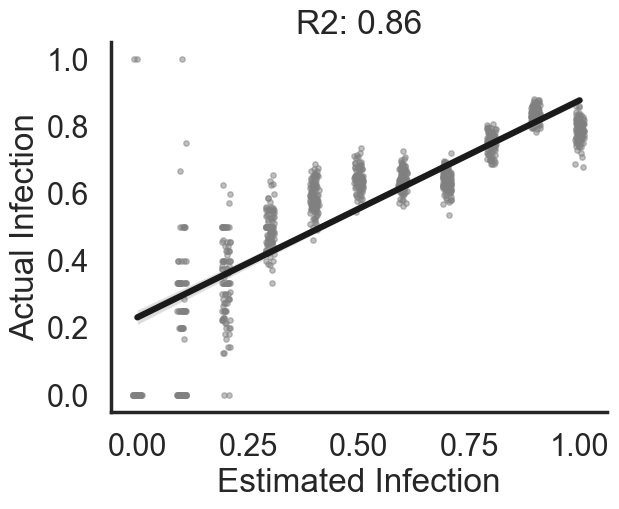

In [72]:
import matplotlib.pyplot as plt

sns.set_theme(context="poster", style="white", font_scale=1)

fig, ax = plt.subplots()

sns.regplot(
    data=bootstrap_counts,
    x="Estimated Infection",
    y="Actual Infection",
    ax=ax,
    scatter_kws={"color": "gray", "alpha": 0.5, "s": 15},
    line_kws={"color": "k", "alpha": 1},
    fit_reg=True,
    ci=95,
    x_jitter=0.01
)

ax.set_title(
    f"R2: {corr:.2f}"
)

sns.despine()

In [73]:
fig.savefig("infection.pdf", dpi=300, bbox_inches="tight")

In [74]:
combined_results.to_csv(
    "design_matrix_test_infection_risk.tsv",
    sep="\t"
)